# 2. Preprocessing, train and valid

- 구글 코랩을 이용
- 성적 평가 지표는 loss, dice(F1-Score와 유사), IOU
 

##  1) 데이터 준비 및 전처리 

In [ ]:

%load_ext autoreload
%autoreload 2

In [ ]:
# 필요 모듈
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image 
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime
import json,itertools
from typing import Optional
from glob import glob

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from tensorflow import keras
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.pyplot as plt


In [ ]:
# 데이터 준비

In [ ]:
# 구글 드라이브와 연결
from google.colab import drive  
drive.mount('/content/drive')
# 파일이 있는 곳으로 이동
%cd 'your path'

Mounted at /content/drive
/content/drive/MyDrive/project/data/uw_image_segmentation


In [ ]:
# 학습 시 필요한 변수들
BATCH_SIZE = 32 # 배치 사이즈
EPOCHS=10 # 반복학습할 횟수
n_splits=5 # Stratified Group K-Fold 분할할 갯수
fold_selected=2 # 1~5 중 선택

In [ ]:
# csv 파일 불러오기
BASE_PATH  = 'your path'
df = pd.read_csv('train.csv')
display(df.head())


,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [ ]:
# 전처리

df.rename(columns = {'class':'class_name'}, inplace = True)
#--------------------------------------------------------------------------
df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
#--------------------------------------------------------------------------
TRAIN_DIR="your_path/train"

# glob를 통하여 이미지파일의 경로를 가져옴
all_train_images = glob_img = glob.glob( TRAIN_DIR + '/*/*/*/*')

#슬라이싱을 하여 case, day, 몇 번째 slice, 이미지 경로, 파일의 width, height를 가져오기 위해 준비 
x = all_train_images[0].rsplit("/", 4)[0] 

# case, day, 몇 번째 slice, 이미지 경로, 파일의 width, height 컬럼을 생성
path_partial_list = []
for i in range(0, df.shape[0]):
    path_partial_list.append(os.path.join(x,
                          "case"+str(df["case"].values[i]),
                          "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                          "scans",
                          "slice_"+str(df["slice"].values[i])))
df["path_partial"] = path_partial_list

path_partial_list = []
for i in range(0, len(all_train_images)):
    path_partial_list.append(str(all_train_images[i].rsplit("_",4)[0]))
    
tmp_df = pd.DataFrame()
tmp_df['path_partial'] = path_partial_list
tmp_df['path'] = all_train_images


df = df.merge(tmp_df, on="path_partial").drop(columns=["path_partial"])

df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))

del x, path_partial_list, tmp_df

# 데이터 프레임 확인
df.head(5)



,id,class_name,segmentation,case,day,slice,path,width,height
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,/content/drive/MyDrive/project/data/uw_image_s...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,/content/drive/MyDrive/project/data/uw_image_s...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,/content/drive/MyDrive/project/data/uw_image_s...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,/content/drive/MyDrive/project/data/uw_image_s...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,/content/drive/MyDrive/project/data/uw_image_s...,266,266


In [ ]:
# 전처리 (이어서)
df_train = pd.DataFrame({'id':df['id'][::3]})

df_train['large_bowel'] = df['segmentation'][::3].values
df_train['small_bowel'] = df['segmentation'][1::3].values
df_train['stomach'] = df['segmentation'][2::3].values

df_train['path'] = df['path'][::3].values
df_train['case'] = df['case'][::3].values
df_train['day'] = df['day'][::3].values
df_train['slice'] = df['slice'][::3].values
df_train['width'] = df['width'][::3].values
df_train['height'] = df['height'][::3].values


df_train.reset_index(inplace=True,drop=True)
df_train.fillna('',inplace=True); 
# 각 id당 라벨링이 몇 개가 되어 있는지 확인을 위해 계산하여 count 컬럼을 생성
df_train['count'] = np.sum(df_train.iloc[:,1:4]!='',axis=1).values
df_train.sample(5)

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
16903,case147_day20_slice_0088,13994 6 14226 7 14258 10 14490 10 14524 14 147...,21157 9 21422 13 21491 8 21686 18 21729 4 2175...,,/content/drive/MyDrive/project/data/uw_image_s...,147,20,0088,266,266,2
32579,case54_day32_slice_0132,,,,/content/drive/MyDrive/project/data/uw_image_s...,54,32,0132,266,266,0
26423,case92_day0_slice_0136,,,,/content/drive/MyDrive/project/data/uw_image_s...,92,0,0136,266,266,0
26357,case92_day0_slice_0070,27325 8 27588 14 27852 18 28117 20 28383 21 28...,,24086 7 24350 11 24616 12 24881 15 25147 16 25...,/content/drive/MyDrive/project/data/uw_image_s...,92,0,0070,266,266,2
1165,case133_day23_slice_0014,,,,/content/drive/MyDrive/project/data/uw_image_s...,133,23,0014,360,310,0


In [ ]:
# 라벨링이 하나도 안되어 있는 데이터를 삭제 후 인덱스 초기화
df_train = df_train[df_train['count']!=0]
df_train.reset_index(inplace=True, drop=True)


  2) 학습 준비

In [ ]:
# rle 인코딩, 디코딩, 마스킹을 위한 함수 생성
def rle_encode(img):
    '''
    img: numpy array 형태, 1 은 mask, 0 은 background
    string 포맷으로 리턴
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape, color=1):
    '''
    rle 인코더와 정반대
    mask_rle: string 포맷 (start length)
    shape: (height,width) of array to return 
    numpy array 형태, 1 은 mask, 0 은 background 형태로 리턴

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def build_masks(labels,input_shape, colors=True):
    height, width = input_shape
    if colors:
        mask = np.zeros((height, width, 3))
        for label in labels:
            mask += rle_decode(label, shape=(height,width , 3), color=np.random.rand(3))
    else:
        mask = np.zeros((height, width, 1))
        for label in labels:
            mask += rle_decode(label, shape=(height, width, 1))
    mask = mask.clip(0, 1)
    return mask

  2 - 1) keras를 이용해 학습 준비

In [ ]:
import keras
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = BATCH_SIZE, subset="train", shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,128,3))
        y = np.empty((self.batch_size,128,128,3))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,img_path in enumerate(self.df['path'].iloc[indexes]):
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            img = self.__load_grayscale(img_path)
            X[i,] =img
            if self.subset == 'train':
                for k,j in zip([0,1,2],["large_bowel","small_bowel","stomach"]):
                    rles=self.df[j].iloc[indexes[i]]
                    masks = rle_decode(rles, shape=(h, w, 1))
                    #rles=df_train[j][df_train.index==indexes[i]]
                    #masks = build_masks(rles,(h,w), colors=False)
                    masks = cv2.resize(masks, (128, 128))
                    y[i,:,:,k] = masks
        if self.subset == 'train': return X, y
        else: return X
        
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        dsize = (128, 128)
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)
        return img

  2 - 2) 학습, 검증을 위한 데이터 셋 생성(Stratified Group K-Fold를 이용)
 
  

In [ ]:
skf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(X=df_train, y=df_train['count'],groups =df_train['case']), 1):
    df_train.loc[val_idx, 'fold'] = fold
    
df_train['fold'] = df_train['fold'].astype(np.uint8)

train_ids = df_train[df_train["fold"]!=fold_selected].index
valid_ids = df_train[df_train["fold"]==fold_selected].index

df_train.groupby('fold').size()

fold
1    3973
2    2806
3    3656
4    3121
5    3034
dtype: int64

In [ ]:
train_generator = DataGenerator(df_train[df_train.index.isin(train_ids)],shuffle=True)
val_generator = DataGenerator(df_train[df_train.index.isin(valid_ids)])

In [ ]:
# 성능 평가를 위한 dice, iou, loss 지표 함수 생성



def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [ ]:
# 학습에 사용할 모델인 segmentation_models 설치
! pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-oxjnie4e
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-oxjnie4e
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 6.8 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=a46b553b3fa3cc25f8e36dee1a6bc0264f9c8a1b9d6f187be1b36c89be165033
  Stored in directory: /tmp/pip-ephem-wheel-cache-aj0a9hri/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()


Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
# 학습 모델 생성
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

model = Unet('efficientnetb7',input_shape=(128, 128, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')
model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef]) #binary_crossentropy
model.summary()

258449408/258434480 [==============================] - 42s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 64, 64, 64)   1728        ['input_1[0][0]']                
                                                                                                  
 stem_bn (BatchNormalization)   (None, 64, 64, 64)   256         ['stem_conv[0][0]']              
                                                                                                  
 stem_activation (Activati

In [ ]:
from keras.callbacks import Callback, ModelCheckpoint
checkpoint_path = "check_point.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True, 
                                                 save_weights_only=True,
                                                 verbose=1)
checkpoint 


In [ ]:
# 학습
history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)
      

Epoch 1/10
430/430 [==============================] - ETA: 0s - loss: 0.2346 - dice_coef: 0.6182 - iou_coef: 0.4739
Epoch 1: val_loss improved from inf to 0.19612, saving model to /content/drive/MyDrive/project/data/uw_image_segmentation/220621.ckpt
430/430 [==============================] - 3368s 8s/step - loss: 0.2346 - dice_coef: 0.6182 - iou_coef: 0.4739 - val_loss: 0.1961 - val_dice_coef: 0.6701 - val_iou_coef: 0.5136
Epoch 2/10
430/430 [==============================] - ETA: 0s - loss: 0.1014 - dice_coef: 0.8287 - iou_coef: 0.7020
Epoch 2: val_loss improved from 0.19612 to 0.17025, saving model to /content/drive/MyDrive/project/data/uw_image_segmentation/220621.ckpt
430/430 [==============================] - 314s 730ms/step - loss: 0.1014 - dice_coef: 0.8287 - iou_coef: 0.7020 - val_loss: 0.1702 - val_dice_coef: 0.7200 - val_iou_coef: 0.5795
Epoch 3/10
430/430 [==============================] - ETA: 0s - loss: 0.0851 - dice_coef: 0.8566 - iou_coef: 0.7422
Epoch 3: val_loss did no

In [ ]:
# 학습결과 저장
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

In [ ]:
# 모델 저장
model.save('model.h5')

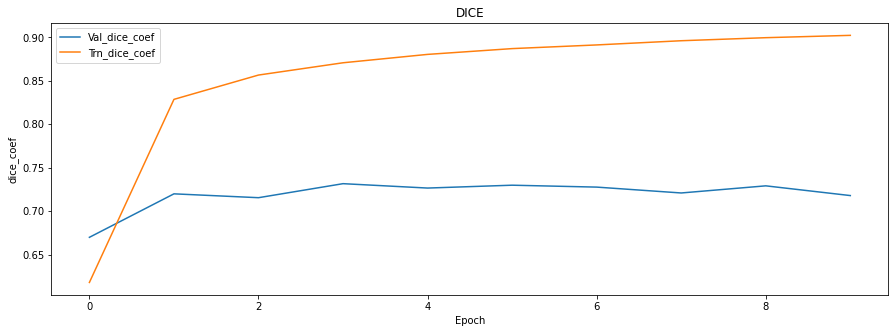

In [ ]:
# 학습결과 시각화 dice score
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 
plt.show()

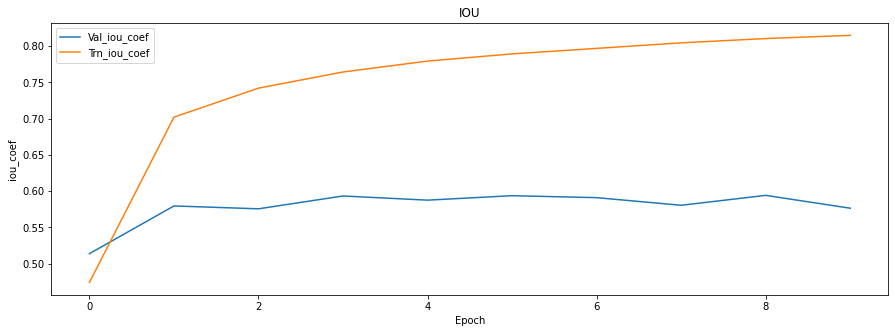

In [ ]:
# 학습결과 시각화 iou score
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Trn_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend(); 
plt.show()

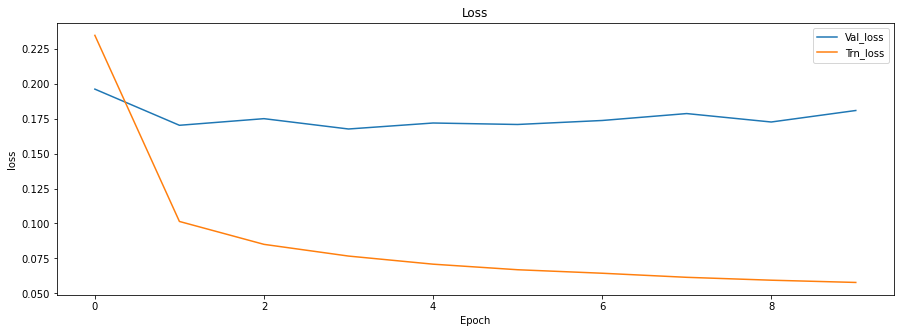

In [ ]:
# 학습결과 시각화 loss
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Trn_loss')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

In [ ]:
import gc
gc.collect()


2730

In [ ]:
# 모델 불러오기
custom_objects = custom_objects={
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'bce_dice_loss': bce_dice_loss  
}
model = load_model('model.h5', custom_objects=custom_objects)

In [ ]:
# 예측할 데이터 셋
pred_batches = DataGenerator(df_train[df_train.index.isin(valid_ids[0:8])],batch_size = 1,shuffle=False)
preds = model.predict_generator(pred_batches,verbose=1)

8/8 [==============================] - 5s 38ms/step


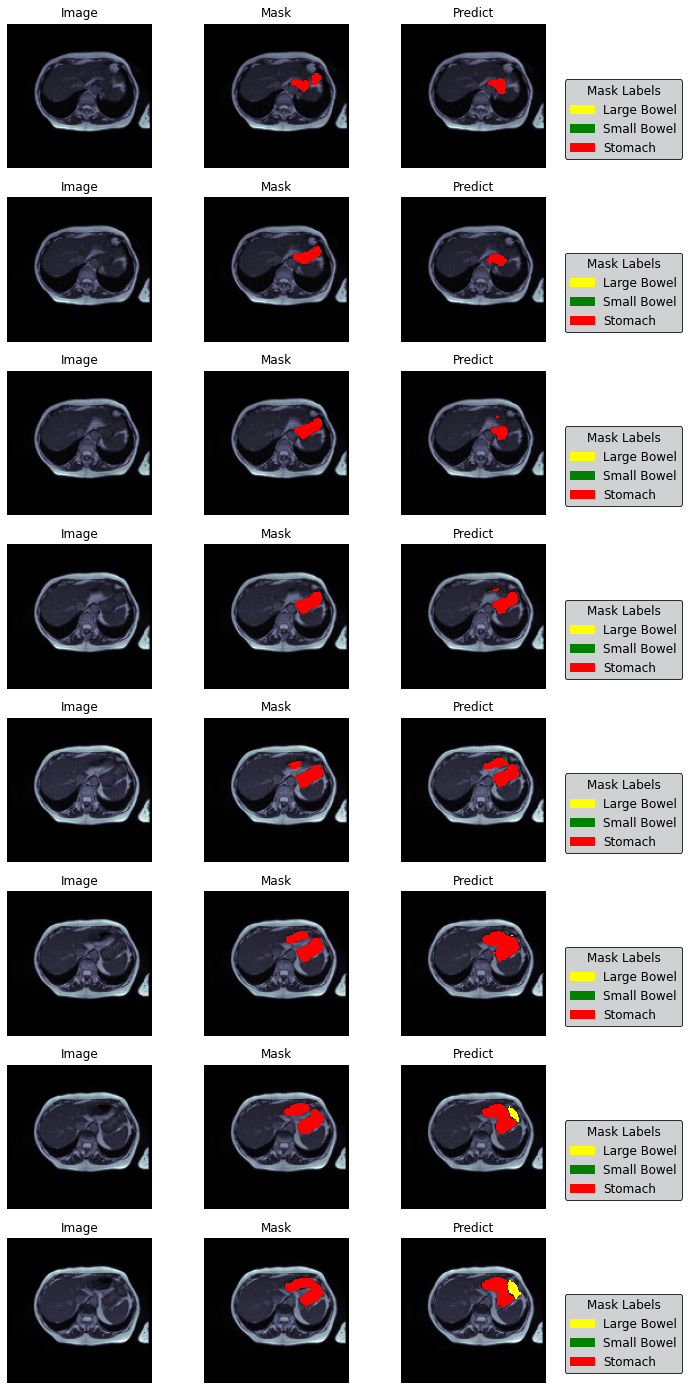

In [ ]:
# 기준점 설정
Threshold = 0.1

# 시각화 준비
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=8, ncols=3)
colors = ['yellow','green','red']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

# 색상 설정
cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3= mpl.colors.ListedColormap(colors[2])

# 예측 결과 시각화
for i in range(8):
    images, mask = pred_batches[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    pre=preds[i]
    predict1=pre[:,:,0]
    predict2=pre[:,:,1]
    predict3=pre[:,:,2]
    
    predict1= (predict1 > Threshold).astype(np.float32)
    predict2= (predict2 > Threshold).astype(np.float32)
    predict3= (predict3 > Threshold).astype(np.float32)
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')
    ax0.set_title("Image", fontsize=12, y=1.01)
    #--------------------------
    ax1 = fig.add_subplot(gs[i, 1])
    ax1.set_title("Mask", fontsize=12,  y=1.01)
    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    #--------------------------
    ax2 = fig.add_subplot(gs[i, 2])
    ax2.set_title("Predict", fontsize=12, y=1.01)
    l0 = ax2.imshow(sample_img, cmap='bone')
    l1 = ax2.imshow(np.ma.masked_where(predict1== False,  predict1),cmap=cmap1, alpha=1)
    l2 = ax2.imshow(np.ma.masked_where(predict2== False,  predict2),cmap=cmap2, alpha=1)
    l3 = ax2.imshow(np.ma.masked_where(predict3== False,  predict3),cmap=cmap3, alpha=1)
   

    _ = [ax.set_axis_off() for ax in [ax0,ax1,ax2]]
    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
    plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 12,title='Mask Labels', title_fontsize=12, edgecolor="black",  facecolor='#c5c6c7')